/home/raxx/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raxx/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_5497/2274767184.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This lim

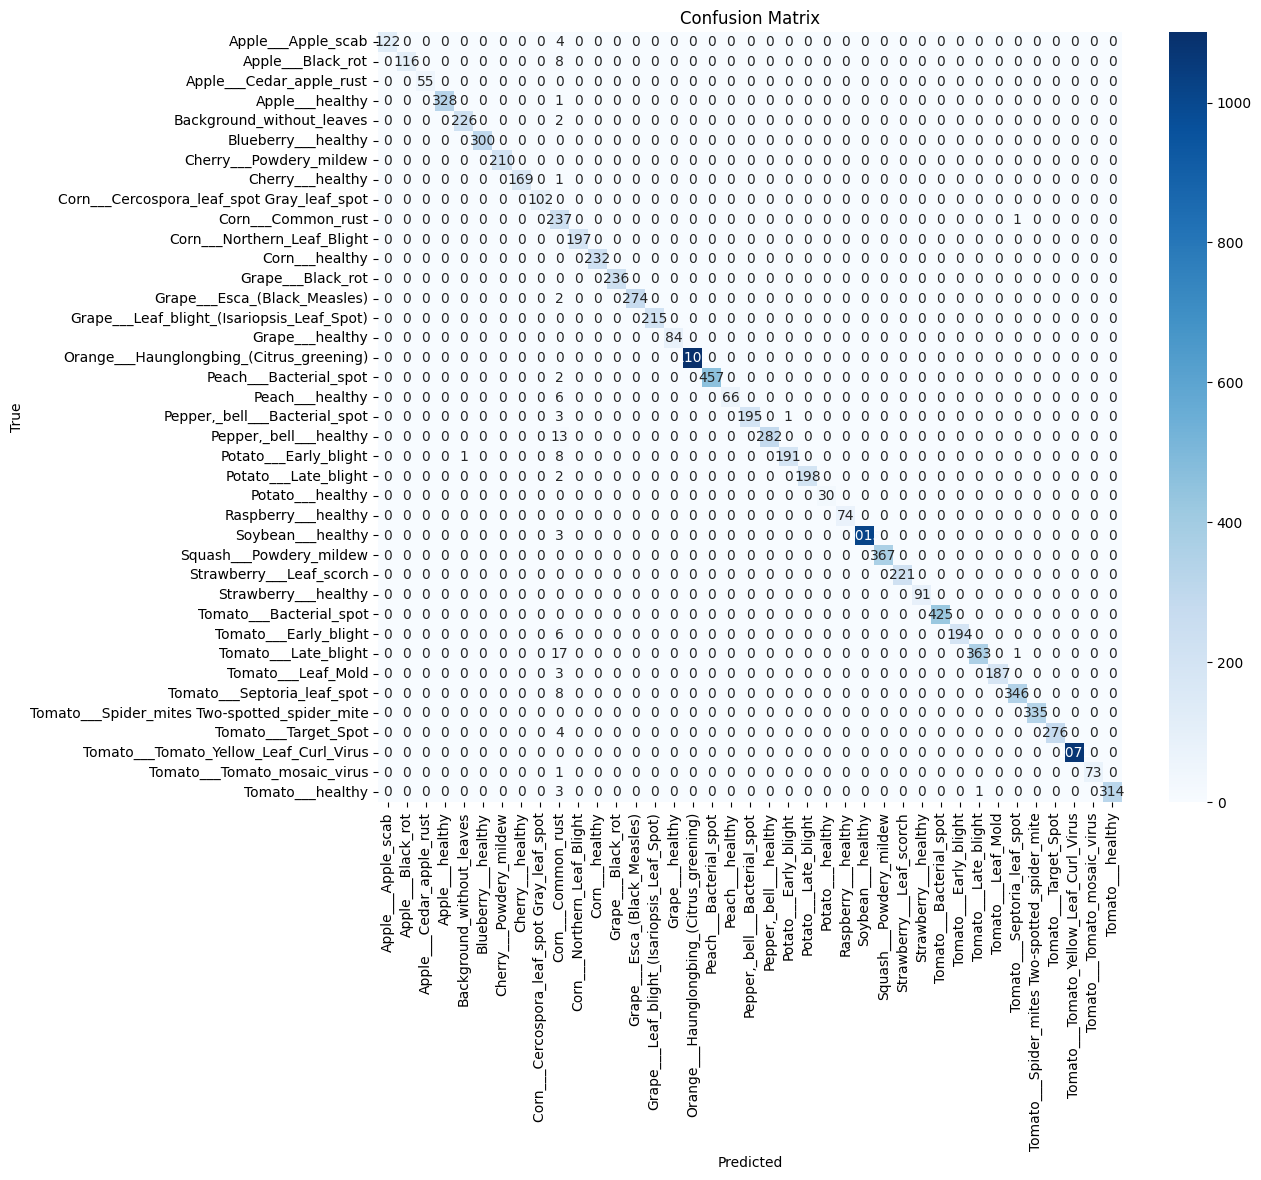

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.97      0.98       126
                            Apple___Black_rot       1.00      0.94      0.97       124
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                              Apple___healthy       1.00      1.00      1.00       329
                    Background_without_leaves       1.00      0.99      0.99       228
                          Blueberry___healthy       1.00      1.00      1.00       300
                      Cherry___Powdery_mildew       1.00      1.00      1.00       210
                             Cherry___healthy       1.00      0.99      1.00       170
   Corn___Cercospora_leaf_spot Gray_leaf_spot       1.00      1.00      1.00       102
                           Corn___Common_rust       0.71      1.00      0.83       238
                  Corn___Northern_Leaf_Bli

In [4]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dir = "test"
model_state_dict_path = "model/full/plant_disease_detection_resnet50_finetuned_42.pth"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_classes = 39
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, num_classes)
)
model.load_state_dict(torch.load(model_state_dict_path))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))
